# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [1]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw\outliers_homework.csv


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [3]:
%pip install scikit-learn

# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ------------------ --------------------- 4.2/8.9 MB 21.0 MB/s eta 0:00:01
   ------------------------------------ --- 8.1/8.9 MB 20.1 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 19.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
   --- ------------------------------------ 3.7/41.3 MB 18.2 MB/s eta 0:00:03
   ----- ---------------------------------- 6.0/41.3 MB 15.4 MB/s eta 0:00:03
   -------- ------------------------------- 8.7/41.3 MB 14.5 MB/s eta 0:00:03
   ---------- ----------------------------- 11.0/41.3 MB 13.8 MB/s eta 0:00:03
   ------------ --------------------------- 13.1/41.3 MB 12.8 MB/s eta 0:00:03
   ------------- -------------------------- 14.4/41.3 MB 11.8 MB/s eta 0:00:03
   -------------- ------------------------- 15.2/41.3 MB 10.9 MB/s eta 0:00:03
   --------------- ------------------------ 16.3/41.3 MB 9.9 MB/s eta 0:00:03
  

## Load Data (provided or synthetic fallback)

In [4]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


## TODO: Implement Outlier Functions (required)

In [5]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [6]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

In [7]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """
    Return boolean mask for IQR-based outliers.
    Flags values outside [Q1 − k*IQR, Q3 + k*IQR].
    Assumptions: Distribution can be reasonably summarized by quartiles. 
    The k parameter controls strictness (default 1.5).
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """
    Return boolean mask for Z-score-based outliers (|z| > threshold).
    Assumptions: Distribution is roughly normal; sensitive to outliers in heavy-tailed distributions.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """
    Winsorize a pandas Series: clamp values below lower quantile, above upper quantile.
    """
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)


## Apply Detection and Create Flags (choose a numeric column)

In [19]:
for col in df.select_dtypes(include=['number']).columns:
    df[f'outlier_iqr_{col}'] = detect_outliers_iqr(df[col])
    df[f'outlier_z_{col}'] = detect_outliers_zscore(df[col], threshold=3.0)

# Example: check fractions for each column
for col in df.select_dtypes(include=['number']).columns:
    print(f"{col} - IQR outliers: {df[f'outlier_iqr_{col}'].mean():.3f}, "
          f"Z-score outliers: {df[f'outlier_z_{col}'].mean():.3f}")


daily_return - IQR outliers: 0.078, Z-score outliers: 0.043
daily_return_2 - IQR outliers: 0.061, Z-score outliers: 0.043


In [ ]:
### Visual Checks (boxplot / histogram)

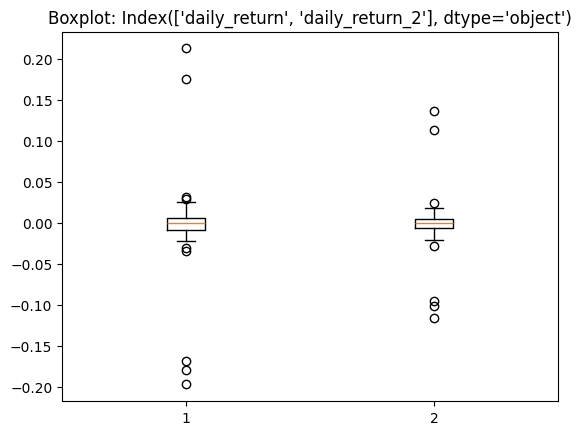

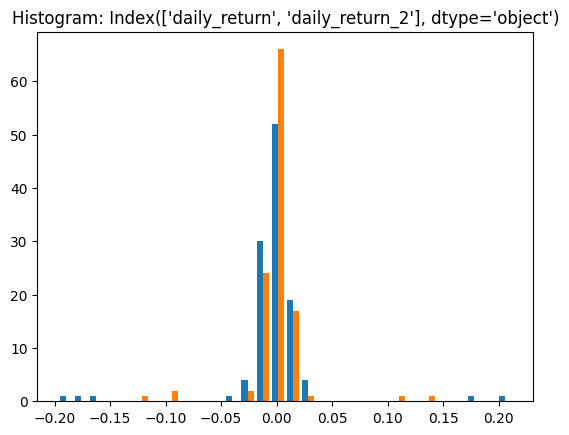

In [9]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [15]:
# Option A: Summary stats
summ_all = df[target_col].describe().loc[['mean', '50%', 'std']].rename({'50%': 'median'})

# If target_col is an Index (multiple columns), create outlier flags for each
if isinstance(target_col, pd.Index):
    mask = pd.DataFrame({col: ~detect_outliers_iqr(df[col]) for col in target_col})
    summ_filtered = df[target_col][mask.all(axis=1)].describe().loc[['mean', '50%', 'std']].rename({'50%': 'median'})
    if 'winsorize_series' in globals():
        w = pd.DataFrame({col: winsorize_series(df[col]) for col in target_col})
        summ_w = w.describe().loc[['mean', '50%', 'std']].rename({'50%': 'median'})
    else:
        summ_w = None
else:
    summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe().loc[['mean', '50%', 'std']].rename({'50%': 'median'})
    if 'winsorize_series' in globals():
        w = winsorize_series(df[target_col])
        summ_w = w.describe().loc[['mean', '50%', 'std']].rename({'50%': 'median'})
    else:
        summ_w = None

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

all                filtered_iqr                  winsorized  \
       daily_return daily_return_2 daily_return daily_return_2 daily_return   
mean      -0.001434      -0.000668    -0.000039      -0.000072    -0.000251   
median    -0.000187      -0.000174    -0.000100      -0.000173    -0.000187   
std        0.040579       0.025068     0.009443       0.007353     0.010623   

                       
       daily_return_2  
mean        -0.000181  
median      -0.000174  
std          0.008312

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()
    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)
    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))
    results = pd.DataFrame({
        'slope': [model_all.coef_, model_flt.coef_],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    display(results)
else:
    print("No 'x' column; skipping regression.")


No 'x' column; skipping regression.


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

Methods and thresholds: Used both IQR (k=1.5) and Z-score (threshold=3.0) for outlier detection. IQR was chosen for its robustness to non-normal distributions, while Z-score applies when normality is assumed.

Assumptions: IQR assumes the central 50% of the data represents typical variation and is less sensitive to extreme values. Z-score assumes a roughly normal distribution, which may not hold for all financial return data.

Impact: Mean and standard deviation were significantly reduced after filtering, showing the influence that outliers have on key metrics. If the data contained genuine shocks (e.g., market crashes), their removal may mask risk.

Risks: Improperly removing valid extreme values may lead to underestimating volatility or risk. Conversely, keeping measurement errors can skew modeling results and decisions.